In [1]:
#Importing DF
import pandas as pd

demographics_path = '/Users/vincent/Desktop/Demographics.xlsx'
demographics_df = pd.read_excel(demographics_path)

demographics_df.head()

,Age (in years),CAO Points (100 to 600),"Daily travel to DCU (in km, 0 if on-campus)",Average year 1 exam result (as %),Seat row in class,Gender,Number of older siblings,Number of younger siblings,Old Dublin postcode (0 if outside Dublin),Height (in cm),Weight (in kg),Eye colour,Hair colour,Last 4 digits of your mobile (0000 to 9999),Star sign,Shoe size
0,21,xxxxx,10,66,4,Male,0,2,0,178.0,92.0,Green,Brown,5262,Capricorn,9.0
1,22,505,xxxxx,68,7,Female,0,1,0,155.0,55.0,Blue,Brown,7181,Leo,4.0
2,20,600,30,xxxxx,6,Female,1,2,0,180.0,55.0,Blue,Brown,7677,Leo,5.0
3,19,543,10,71,xxxxx,Male,0,1,13,187.0,76.0,Blue,Red,838,Taurus,9.0
4,xxxxx,407,8,73,1,Male,2,0,15,181.0,87.0,Blue,Brown,6290,Cancer,9.5


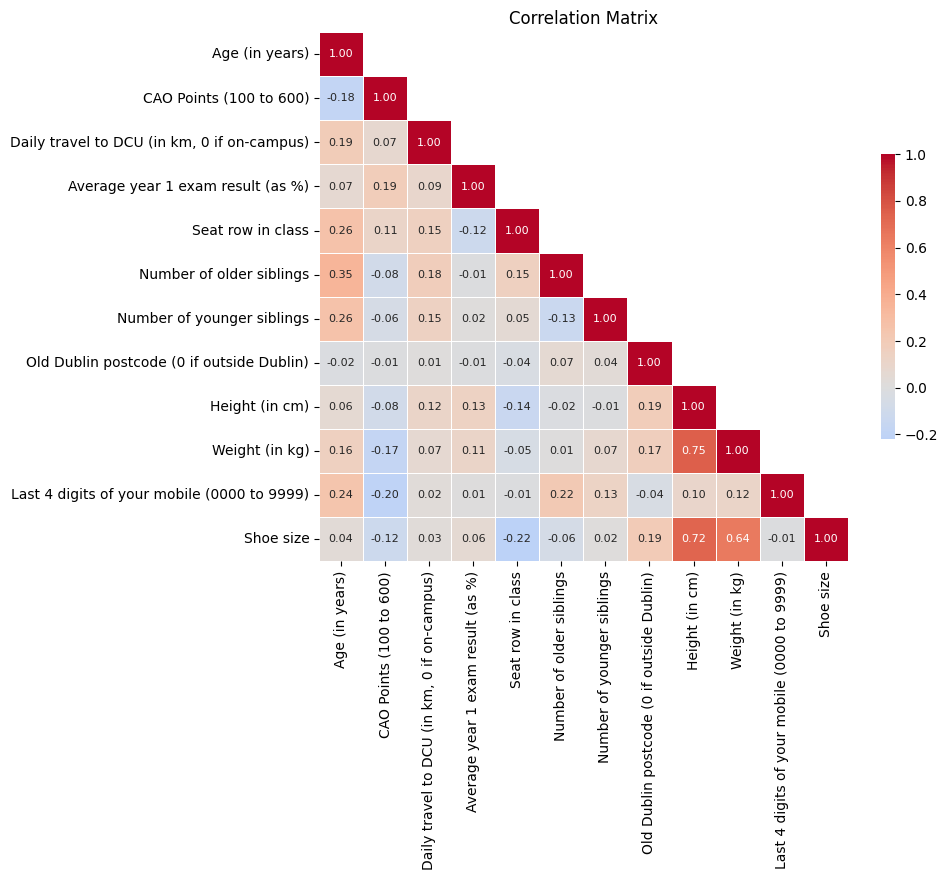

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

# Identification of Correlation 

columns_to_convert = [
    'Age (in years)',  
    'CAO Points (100 to 600)', 
    'Daily travel to DCU (in km, 0 if on-campus)',
    'Average year 1 exam result (as %)', 
    'Seat row in class'
]

for column in columns_to_convert:
    demographics_df[column] = pd.to_numeric(demographics_df[column], errors='coerce')

numeric_df = demographics_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

# Mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(10, 8.8))

# Plot the base heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=".2f",
            annot=True, annot_kws={"size": 8})

plt.title('Correlation Matrix')
plt.tight_layout()

png_path = '/Users/vincent/Desktop/As.1/CorrelationMatrix.png'

plt.savefig(png_path, bbox_inches='tight', dpi=600)

plt.show()

In [3]:
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

columns_of_interest = [
    'Age (in years)',
    'CAO Points (100 to 600)',
    'Daily travel to DCU (in km, 0 if on-campus)',
    'Average year 1 exam result (as %)',
    'Seat row in class'
]
# Initialize a dictionary to hold all significant correlations for each column of interest
all_significant_correlations = {}

for column in columns_of_interest:
    # Initialize a list to hold tuples of (target_column, correlation coefficient, p-value)
    correlations_with_p = []
    
    for target_column in numeric_df.columns:
        if column == target_column:
            continue  # Skip self-correlation
        
        # Prepare the data by dropping rows where either column has NA values
        valid_data = demographics_df[[column, target_column]].dropna()
        
        if len(valid_data) >= 2:
            # Calculate Pearson correlation coefficient and p-value
            r, p_value = stats.pearsonr(valid_data[column], valid_data[target_column])
            # Store the result along with the column name if p-value indicates significance
            if p_value < 0.05:
                correlations_with_p.append((target_column, r, p_value))  # Store actual r value (not abs(r))
    
    # Sort the list of tuples by the absolute correlation coefficient in descending order
    correlations_with_p.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Store all statistically significant correlations
    all_significant_correlations[column] = correlations_with_p

# Check for multicollinearity and print results including correlation, p-value, and VIF
for column, correlations in all_significant_correlations.items():
    print(f"Statistically significant correlations for '{column}':")
    
    # Prepare DataFrame for VIF analysis including the column of interest
    variables_for_vif = [column] + [corr[0] for corr in correlations]
    df_vif = demographics_df[variables_for_vif].dropna()
    df_vif = add_constant(df_vif)
    
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    
    # Match VIF values back to correlations
    for target, r, p_value in correlations:
        vif = vif_data[vif_data['Variable'] == target]['VIF'].values[0] if target in vif_data['Variable'].values else 'N/A'
        print(f"  {target}: Correlation = {r:.3f}, P-value = {p_value:.3g}, VIF = {vif}")
    
    print("\n")

Statistically significant correlations for 'Age (in years)':
  Number of older siblings: Correlation = 0.348, P-value = 9.27e-05, VIF = 1.2822188302900963
  Number of younger siblings: Correlation = 0.258, P-value = 0.00423, VIF = 1.1799834385199282
  Seat row in class: Correlation = 0.257, P-value = 0.00454, VIF = 1.0978779951651136
  Last 4 digits of your mobile (0000 to 9999): Correlation = 0.242, P-value = 0.00737, VIF = 1.1091412530814437
  Daily travel to DCU (in km, 0 if on-campus): Correlation = 0.191, P-value = 0.0368, VIF = 1.0888113120953007


Statistically significant correlations for 'CAO Points (100 to 600)':
  Last 4 digits of your mobile (0000 to 9999): Correlation = -0.205, P-value = 0.0241, VIF = 1.0537720019786485
  Average year 1 exam result (as %): Correlation = 0.187, P-value = 0.0404, VIF = 1.0389750985058679


Statistically significant correlations for 'Daily travel to DCU (in km, 0 if on-campus)':
  Age (in years): Correlation = 0.191, P-value = 0.0368, VIF = 1

In [4]:
#Prediction model for Age column, all values with statistical significance and no multicollinearity concern are used 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

predictors = [
    'Number of older siblings', 
    'Number of younger siblings', 
    'Seat row in class', 
    'Last 4 digits of your mobile (0000 to 9999)',
    'Daily travel to DCU (in km, 0 if on-campus)'
]

df_notnull = demographics_df.dropna(subset=['Age (in years)'] + predictors)

X = df_notnull[predictors]
y = df_notnull['Age (in years)']

model = LinearRegression()
model.fit(X, y)

df_null = demographics_df[demographics_df['Age (in years)'].isnull() & demographics_df[predictors].notnull().all(axis=1)]
X_null = df_null[predictors]

if not X_null.empty:
    predicted_age = model.predict(X_null)
    demographics_df.loc[demographics_df['Age (in years)'].isnull() & demographics_df[predictors].notnull().all(axis=1), 'Age (in years)'] = predicted_age

demographics_df.head()

,Age (in years),CAO Points (100 to 600),"Daily travel to DCU (in km, 0 if on-campus)",Average year 1 exam result (as %),Seat row in class,Gender,Number of older siblings,Number of younger siblings,Old Dublin postcode (0 if outside Dublin),Height (in cm),Weight (in kg),Eye colour,Hair colour,Last 4 digits of your mobile (0000 to 9999),Star sign,Shoe size
0,21.000000,NaN,10.0,66.0,4.0,Male,0,2,0,178.0,92.0,Green,Brown,5262,Capricorn,9.0
1,22.000000,505.0,NaN,68.0,7.0,Female,0,1,0,155.0,55.0,Blue,Brown,7181,Leo,4.0
2,20.000000,600.0,30.0,NaN,6.0,Female,1,2,0,180.0,55.0,Blue,Brown,7677,Leo,5.0
3,19.000000,543.0,10.0,71.0,NaN,Male,0,1,13,187.0,76.0,Blue,Red,838,Taurus,9.0
4,20.683437,407.0,8.0,73.0,1.0,Male,2,0,15,181.0,87.0,Blue,Brown,6290,Cancer,9.5


In [5]:
#Prediction model for CAO column

predictors_for_cao_points = ['Last 4 digits of your mobile (0000 to 9999)', 'Average year 1 exam result (as %)']

df_notnull = demographics_df.dropna(subset=['CAO Points (100 to 600)'] + predictors_for_cao_points)

X = df_notnull[predictors_for_cao_points]
y = df_notnull['CAO Points (100 to 600)']

model = LinearRegression()
model.fit(X, y)

df_null = demographics_df[demographics_df['CAO Points (100 to 600)'].isnull() & demographics_df[predictors_for_cao_points].notnull().all(axis=1)]
X_null = df_null[predictors_for_cao_points]

if not X_null.empty:
    predicted_cao_points = model.predict(X_null)
    demographics_df.loc[demographics_df['CAO Points (100 to 600)'].isnull() & demographics_df[predictors_for_cao_points].notnull().all(axis=1), 'CAO Points (100 to 600)'] = predicted_cao_points

demographics_df.head()

,Age (in years),CAO Points (100 to 600),"Daily travel to DCU (in km, 0 if on-campus)",Average year 1 exam result (as %),Seat row in class,Gender,Number of older siblings,Number of younger siblings,Old Dublin postcode (0 if outside Dublin),Height (in cm),Weight (in kg),Eye colour,Hair colour,Last 4 digits of your mobile (0000 to 9999),Star sign,Shoe size
0,21.000000,481.67636,10.0,66.0,4.0,Male,0,2,0,178.0,92.0,Green,Brown,5262,Capricorn,9.0
1,22.000000,505.00000,NaN,68.0,7.0,Female,0,1,0,155.0,55.0,Blue,Brown,7181,Leo,4.0
2,20.000000,600.00000,30.0,NaN,6.0,Female,1,2,0,180.0,55.0,Blue,Brown,7677,Leo,5.0
3,19.000000,543.00000,10.0,71.0,NaN,Male,0,1,13,187.0,76.0,Blue,Red,838,Taurus,9.0
4,20.683437,407.00000,8.0,73.0,1.0,Male,2,0,15,181.0,87.0,Blue,Brown,6290,Cancer,9.5


In [6]:
#Prediction for Travel to DCU

predictors_for_daily_travel = ['Age (in years)']

df_notnull = demographics_df.dropna(subset=['Daily travel to DCU (in km, 0 if on-campus)'] + predictors_for_daily_travel)

X = df_notnull[predictors_for_daily_travel]
y = df_notnull['Daily travel to DCU (in km, 0 if on-campus)']

model = LinearRegression()
model.fit(X, y)

df_null = demographics_df[demographics_df['Daily travel to DCU (in km, 0 if on-campus)'].isnull() & demographics_df[predictors_for_daily_travel].notnull().all(axis=1)]
X_null = df_null[predictors_for_daily_travel]

if not X_null.empty:
    predicted_daily_travel = model.predict(X_null)
   
    demographics_df.loc[demographics_df['Daily travel to DCU (in km, 0 if on-campus)'].isnull() & demographics_df[predictors_for_daily_travel].notnull().all(axis=1), 'Daily travel to DCU (in km, 0 if on-campus)'] = predicted_daily_travel

demographics_df.head()

,Age (in years),CAO Points (100 to 600),"Daily travel to DCU (in km, 0 if on-campus)",Average year 1 exam result (as %),Seat row in class,Gender,Number of older siblings,Number of younger siblings,Old Dublin postcode (0 if outside Dublin),Height (in cm),Weight (in kg),Eye colour,Hair colour,Last 4 digits of your mobile (0000 to 9999),Star sign,Shoe size
0,21.000000,481.67636,10.000000,66.0,4.0,Male,0,2,0,178.0,92.0,Green,Brown,5262,Capricorn,9.0
1,22.000000,505.00000,10.021348,68.0,7.0,Female,0,1,0,155.0,55.0,Blue,Brown,7181,Leo,4.0
2,20.000000,600.00000,30.000000,NaN,6.0,Female,1,2,0,180.0,55.0,Blue,Brown,7677,Leo,5.0
3,19.000000,543.00000,10.000000,71.0,NaN,Male,0,1,13,187.0,76.0,Blue,Red,838,Taurus,9.0
4,20.683437,407.00000,8.000000,73.0,1.0,Male,2,0,15,181.0,87.0,Blue,Brown,6290,Cancer,9.5


In [7]:
#Prediction for year 1 results

predictors_for_avg_year_1_results = ['CAO Points (100 to 600)']

df_notnull = demographics_df.dropna(subset=['Average year 1 exam result (as %)'] + predictors_for_avg_year_1_results)

X = df_notnull[predictors_for_avg_year_1_results]
y = df_notnull['Average year 1 exam result (as %)']

model = LinearRegression()
model.fit(X, y)

df_null = demographics_df[demographics_df['Average year 1 exam result (as %)'].isnull() & demographics_df[predictors_for_avg_year_1_results].notnull().all(axis=1)]
X_null = df_null[predictors_for_avg_year_1_results]

if not X_null.empty:
    predicted_avg_year_1_results = model.predict(X_null)
    demographics_df.loc[demographics_df['Average year 1 exam result (as %)'].isnull() & demographics_df[predictors_for_avg_year_1_results].notnull().all(axis=1), 'Average year 1 exam result (as %)'] = predicted_avg_year_1_results

demographics_df.head()

,Age (in years),CAO Points (100 to 600),"Daily travel to DCU (in km, 0 if on-campus)",Average year 1 exam result (as %),Seat row in class,Gender,Number of older siblings,Number of younger siblings,Old Dublin postcode (0 if outside Dublin),Height (in cm),Weight (in kg),Eye colour,Hair colour,Last 4 digits of your mobile (0000 to 9999),Star sign,Shoe size
0,21.000000,481.67636,10.000000,66.000000,4.0,Male,0,2,0,178.0,92.0,Green,Brown,5262,Capricorn,9.0
1,22.000000,505.00000,10.021348,68.000000,7.0,Female,0,1,0,155.0,55.0,Blue,Brown,7181,Leo,4.0
2,20.000000,600.00000,30.000000,70.917807,6.0,Female,1,2,0,180.0,55.0,Blue,Brown,7677,Leo,5.0
3,19.000000,543.00000,10.000000,71.000000,NaN,Male,0,1,13,187.0,76.0,Blue,Red,838,Taurus,9.0
4,20.683437,407.00000,8.000000,73.000000,1.0,Male,2,0,15,181.0,87.0,Blue,Brown,6290,Cancer,9.5


In [8]:
#Prediction for Seat row in class
predictors_for_seat_row = ['Age (in years)', 'Shoe size']

df_notnull = demographics_df.dropna(subset=['Seat row in class'] + predictors_for_seat_row)

X = df_notnull[predictors_for_seat_row]
y = df_notnull['Seat row in class']

model = LinearRegression()
model.fit(X, y)

df_null = demographics_df[demographics_df['Seat row in class'].isnull() & demographics_df[predictors_for_seat_row].notnull().all(axis=1)]
X_null = df_null[predictors_for_seat_row]

if not X_null.empty:
    predicted_seat_row = model.predict(X_null)
    demographics_df.loc[demographics_df['Seat row in class'].isnull() & demographics_df[predictors_for_seat_row].notnull().all(axis=1), 'Seat row in class'] = predicted_seat_row

demographics_df.head()

,Age (in years),CAO Points (100 to 600),"Daily travel to DCU (in km, 0 if on-campus)",Average year 1 exam result (as %),Seat row in class,Gender,Number of older siblings,Number of younger siblings,Old Dublin postcode (0 if outside Dublin),Height (in cm),Weight (in kg),Eye colour,Hair colour,Last 4 digits of your mobile (0000 to 9999),Star sign,Shoe size
0,21.000000,481.67636,10.000000,66.000000,4.000000,Male,0,2,0,178.0,92.0,Green,Brown,5262,Capricorn,9.0
1,22.000000,505.00000,10.021348,68.000000,7.000000,Female,0,1,0,155.0,55.0,Blue,Brown,7181,Leo,4.0
2,20.000000,600.00000,30.000000,70.917807,6.000000,Female,1,2,0,180.0,55.0,Blue,Brown,7677,Leo,5.0
3,19.000000,543.00000,10.000000,71.000000,5.014425,Male,0,1,13,187.0,76.0,Blue,Red,838,Taurus,9.0
4,20.683437,407.00000,8.000000,73.000000,1.000000,Male,2,0,15,181.0,87.0,Blue,Brown,6290,Cancer,9.5


In [9]:
# Load dataframe and identify columns to merge
personalities_path = '/Users/vincent/Desktop/Personalities.xlsx'
personalities_df = pd.read_excel(personalities_path)

print("Demographics DataFrame columns:", demographics_df.columns.tolist())
print("Personalities DataFrame columns:", personalities_df.columns.tolist())

Demographics DataFrame columns: ['Age (in years)', 'CAO Points (100 to 600)', 'Daily travel to DCU (in km, 0 if on-campus)', 'Average year 1 exam result (as %)', 'Seat row in class', 'Gender', 'Number of older siblings', 'Number of younger siblings', 'Old Dublin postcode (0 if outside Dublin)', 'Height (in cm)', 'Weight (in kg)', 'Eye colour', 'Hair colour', 'Last 4 digits of your mobile (0000 to 9999)', 'Star sign', 'Shoe size']
Personalities DataFrame columns: ['Last 4 digits of your mobile (same as on previous form)', 'Your rating for EXTRAVERSION (vs. introversion)', 'Your rating for INTUITION (vs. observation)', 'Your rating for THINKING (vs. feeling)', 'Your rating for JUDGING (vs. prospecting)', 'Your rating for ASSERTIVE (vs. turbulent)']


In [10]:
#Merging the dataframes
merged_df = pd.merge(demographics_df, personalities_df, 
                     left_on='Last 4 digits of your mobile (0000 to 9999)', 
                     right_on='Last 4 digits of your mobile (same as on previous form)',  # Use the correct column name as identified
                     how='inner')
merged_df.drop(columns=['Last 4 digits of your mobile (same as on previous form)'], inplace=True)

merged_df.head()

,Age (in years),CAO Points (100 to 600),"Daily travel to DCU (in km, 0 if on-campus)",Average year 1 exam result (as %),Seat row in class,Gender,Number of older siblings,Number of younger siblings,Old Dublin postcode (0 if outside Dublin),Height (in cm),...,Eye colour,Hair colour,Last 4 digits of your mobile (0000 to 9999),Star sign,Shoe size,Your rating for EXTRAVERSION (vs. introversion),Your rating for INTUITION (vs. observation),Your rating for THINKING (vs. feeling),Your rating for JUDGING (vs. prospecting),Your rating for ASSERTIVE (vs. turbulent)
0,22.0,505.0,10.021348,68.0,7.000000,Female,0,1,0,155.0,...,Blue,Brown,7181,Leo,4.0,32,62,23,35,31
1,19.0,543.0,10.000000,71.0,5.014425,Male,0,1,13,187.0,...,Blue,Red,838,Taurus,9.0,48,41,57,49,36
2,21.0,557.0,15.000000,50.5,10.000000,Male,2,0,15,178.0,...,Green,Brown,4397,Aries,7.0,74,48,43,29,63
3,21.0,557.0,15.000000,50.5,10.000000,Male,2,0,15,178.0,...,Green,Brown,4397,Aries,7.0,65,70,70,65,60
4,22.0,397.0,5.000000,65.0,5.000000,Female,2,0,0,153.0,...,Brown,Brown,8626,Sagittarius,5.0,25,55,43,61,44


In [11]:
merged_df.to_csv('/Users/vincent/Desktop/merged_data.csv', index=False)

merged_df.head()

,Age (in years),CAO Points (100 to 600),"Daily travel to DCU (in km, 0 if on-campus)",Average year 1 exam result (as %),Seat row in class,Gender,Number of older siblings,Number of younger siblings,Old Dublin postcode (0 if outside Dublin),Height (in cm),...,Eye colour,Hair colour,Last 4 digits of your mobile (0000 to 9999),Star sign,Shoe size,Your rating for EXTRAVERSION (vs. introversion),Your rating for INTUITION (vs. observation),Your rating for THINKING (vs. feeling),Your rating for JUDGING (vs. prospecting),Your rating for ASSERTIVE (vs. turbulent)
0,22.0,505.0,10.021348,68.0,7.000000,Female,0,1,0,155.0,...,Blue,Brown,7181,Leo,4.0,32,62,23,35,31
1,19.0,543.0,10.000000,71.0,5.014425,Male,0,1,13,187.0,...,Blue,Red,838,Taurus,9.0,48,41,57,49,36
2,21.0,557.0,15.000000,50.5,10.000000,Male,2,0,15,178.0,...,Green,Brown,4397,Aries,7.0,74,48,43,29,63
3,21.0,557.0,15.000000,50.5,10.000000,Male,2,0,15,178.0,...,Green,Brown,4397,Aries,7.0,65,70,70,65,60
4,22.0,397.0,5.000000,65.0,5.000000,Female,2,0,0,153.0,...,Brown,Brown,8626,Sagittarius,5.0,25,55,43,61,44


In [12]:
file_path = '/Users/vincent/Desktop/merged_data.csv'
data = pd.read_csv(file_path)

description_stats = merged_df.describe()

# Calculate median for numeric columns only and create a DataFrame for easy appending
median_series = merged_df.median(numeric_only=True)
median_df = pd.DataFrame(median_series).transpose()
median_df.index = ['median']

# Append the median row to the description DataFrame
# Since pd.concat() is used, ensure to align columns using .reindex() method on median_df to match description_stats columns
description_with_median = pd.concat([description_stats, median_df.reindex(columns=description_stats.columns)], axis=0)

description_with_median

,Age (in years),CAO Points (100 to 600),"Daily travel to DCU (in km, 0 if on-campus)",Average year 1 exam result (as %),Seat row in class,Number of older siblings,Number of younger siblings,Old Dublin postcode (0 if outside Dublin),Height (in cm),Weight (in kg),Last 4 digits of your mobile (0000 to 9999),Shoe size,Your rating for EXTRAVERSION (vs. introversion),Your rating for INTUITION (vs. observation),Your rating for THINKING (vs. feeling),Your rating for JUDGING (vs. prospecting),Your rating for ASSERTIVE (vs. turbulent)
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,21.588235,501.205882,10.962079,68.529412,6.103153,1.220588,0.867647,5.117647,175.441176,71.198529,4478.044118,7.757353,54.852941,54.941176,47.632353,55.485294,46.191176
std,4.863005,68.884623,18.413695,9.495043,2.813209,1.048746,0.912671,5.842534,10.356889,12.579046,2746.299423,2.422674,18.576397,13.678486,14.895561,17.652105,19.821033
min,18.000000,130.000000,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,153.000000,51.000000,111.000000,3.000000,6.000000,7.000000,7.000000,7.000000,6.000000
25%,20.000000,494.750000,2.000000,65.000000,4.000000,0.000000,0.000000,0.000000,168.750000,62.000000,1786.750000,6.000000,44.250000,48.000000,38.250000,44.000000,31.750000
50%,21.000000,511.000000,5.000000,68.000000,5.000000,1.000000,1.000000,1.500000,175.000000,69.000000,4325.000000,7.750000,60.000000,55.000000,47.500000,58.000000,44.000000
75%,22.000000,545.000000,10.005337,73.000000,8.000000,2.000000,1.000000,9.000000,182.000000,80.000000,6954.000000,10.000000,66.500000,66.000000,59.000000,67.250000,60.000000
max,58.000000,578.000000,103.000000,95.000000,12.000000,4.000000,4.000000,22.000000,197.000000,104.000000,9898.000000,13.000000,88.000000,81.000000,82.000000,94.000000,93.000000
median,21.000000,511.000000,5.000000,68.000000,5.000000,1.000000,1.000000,1.500000,175.000000,69.000000,4325.000000,7.750000,60.000000,55.000000,47.500000,58.000000,44.000000


In [13]:
#Average age is approximately 21.6 years, with a wide age range (18 to 58 years), indicating both traditional and non-traditional students.
#Average CAO points score is around 501.2, with scores ranging from 130 to 578, showing a wide range of academic abilities.
#Students travel an average of 10.94 km, with a broad range from 0 to 103 km, highlighting varied commuting distances.
#The average Year 1 exam result is 68.53%, with results ranging from 42% to 95%, indicating diverse academic performance.
#Students have an average of 1.22 older and 0.87 younger siblings, suggesting insights into family sizes.
#With an average 'Old Dublin postcode' value of 5.12 and a maximum of 22, data indicates many students live outside central Dublin.
#Averages for height (175.44 cm), weight (71.20 kg), and shoe size (7.76) show physical diversity among students.
#Students provided mid-scale average ratings on traits like Extraversion, Intuition, etc., showing a balanced mix of personalities but with wide score ranges.
#Maximum values for age, daily travel, height, and weight significantly exceed the 75th percentile, suggesting outliers in the dataset.



In [14]:
# there are outliers in the personality data which are most likely wrong data entries 

columns_of_interest = [
    'Your rating for EXTRAVERSION (vs. introversion)',
    'Your rating for INTUITION (vs. observation)',
    'Your rating for THINKING (vs. feeling)',
    'Your rating for JUDGING (vs. prospecting)',
    'Your rating for ASSERTIVE (vs. turbulent)'
]

# Initialize a dictionary to hold all significant correlations for each column of interest
all_significant_correlations = {}

for column in columns_of_interest:
    # Initialize a list to hold tuples of (target_column, correlation coefficient, p-value)
    correlations_with_p = []
    
    for target_column in numeric_df.columns:
        if column == target_column:
            continue  # Skip self-correlation
        
        # Prepare the data by dropping rows where either column has NA values
        valid_data = merged_df[[column, target_column]].dropna()
        
        if len(valid_data) >= 2:
            # Calculate Pearson correlation coefficient and p-value
            r, p_value = stats.pearsonr(valid_data[column], valid_data[target_column])
            # Store the result along with the column name if p-value indicates significance
            if p_value < 0.05:
                correlations_with_p.append((target_column, r, p_value))  # Store actual r value (not abs(r))
    
    # Sort the list of tuples by the absolute correlation coefficient in descending order
    correlations_with_p.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Store all statistically significant correlations
    all_significant_correlations[column] = correlations_with_p

# Check for multicollinearity and print results including correlation, p-value, and VIF
for column, correlations in all_significant_correlations.items():
    print(f"Statistically significant correlations for '{column}':")
    
    # Prepare DataFrame for VIF analysis including the column of interest
    variables_for_vif = [column] + [corr[0] for corr in correlations]
    df_vif = merged_df[variables_for_vif].dropna()
    df_vif = add_constant(df_vif)
    
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    
    # Match VIF values back to correlations
    for target, r, p_value in correlations:
        vif = vif_data[vif_data['Variable'] == target]['VIF'].values[0] if target in vif_data['Variable'].values else 'N/A'
        print(f"  {target}: Correlation = {r:.3f}, P-value = {p_value:.3g}, VIF = {vif}")
    
    print("\n")

Statistically significant correlations for 'Your rating for EXTRAVERSION (vs. introversion)':


Statistically significant correlations for 'Your rating for INTUITION (vs. observation)':
  Weight (in kg): Correlation = -0.268, P-value = 0.027, VIF = 3.672710687116721
  Height (in cm): Correlation = -0.267, P-value = 0.0277, VIF = 3.67009813090761


Statistically significant correlations for 'Your rating for THINKING (vs. feeling)':


Statistically significant correlations for 'Your rating for JUDGING (vs. prospecting)':
  Last 4 digits of your mobile (0000 to 9999): Correlation = 0.258, P-value = 0.0339, VIF = 1.071081139664809
  Number of older siblings: Correlation = 0.246, P-value = 0.0434, VIF = 1.064234653162035


Statistically significant correlations for 'Your rating for ASSERTIVE (vs. turbulent)':
  Average year 1 exam result (as %): Correlation = 0.300, P-value = 0.0128, VIF = 1.0992327880241277




In [15]:
#test if regression makes sense, assuming an input error

# Create a copy of the DataFrame to work with
merged_df_copy = merged_df.copy()

# Replace the minimum value in 'Your rating for JUDGING (vs. prospecting)' column with NaN
min_value = merged_df_copy['Your rating for JUDGING (vs. prospecting)'].min()
merged_df_copy.loc[merged_df_copy['Your rating for JUDGING (vs. prospecting)'] == min_value, 'Your rating for JUDGING (vs. prospecting)'] = np.nan

train_data = merged_df_copy.dropna(subset=['Your rating for JUDGING (vs. prospecting)', 'Number of older siblings'])

X_train = train_data[['Number of older siblings']]  # Predictor variables
y_train = train_data['Your rating for JUDGING (vs. prospecting)']  # Response variable

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the missing values using the model
X_missing = merged_df_copy[merged_df_copy['Your rating for JUDGING (vs. prospecting)'].isnull()][['Number of older siblings']]
predicted_values = model.predict(X_missing)

# Output the predicted values without altering the dataframe
print(predicted_values)

[55.31556546]


In [16]:
#test if regression makes sense, assuming an input error

# Create a copy of the DataFrame to work with
merged_df_copy = merged_df.copy()

# Replace the minimum value in 'Your rating for ASSERTIVE (vs. turbulent)' column with NaN
min_value = merged_df_copy['Your rating for ASSERTIVE (vs. turbulent)'].min()
merged_df_copy.loc[merged_df_copy['Your rating for ASSERTIVE (vs. turbulent)'] == min_value, 'Your rating for ASSERTIVE (vs. turbulent)'] = np.nan

train_data = merged_df_copy.dropna(subset=['Your rating for ASSERTIVE (vs. turbulent)', 'Average year 1 exam result (as %)'])

X_train = train_data[['Average year 1 exam result (as %)']]  # Predictor variables
y_train = train_data['Your rating for ASSERTIVE (vs. turbulent)']  # Response variable

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the missing values using the model
X_missing = merged_df_copy[merged_df_copy['Your rating for ASSERTIVE (vs. turbulent)'].isnull()][['Average year 1 exam result (as %)']]
predicted_values = model.predict(X_missing)

# Output the predicted values without altering the dataframe
print(predicted_values)

[46.45594226]


In [17]:
# Create a copy of the DataFrame to work with
merged_df_copy = merged_df.copy()

# Replace the minimum value in 'Your rating for INTUITION (vs. observation)' column with NaN
min_value = merged_df_copy['Your rating for INTUITION (vs. observation)'].min()
merged_df_copy.loc[merged_df_copy['Your rating for INTUITION (vs. observation)'] == min_value, 'Your rating for INTUITION (vs. observation)'] = np.nan

# Prepare the data for linear regression
# Using 'Weight (in kg)' and 'Height (in cm)' as predictors for 'Your rating for INTUITION (vs. observation)'
train_data = merged_df_copy.dropna(subset=['Your rating for INTUITION (vs. observation)', 'Weight (in kg)', 'Height (in cm)'])

X_train = train_data[['Weight (in kg)', 'Height (in cm)']]  # Predictor variables
y_train = train_data['Your rating for INTUITION (vs. observation)']  # Response variable

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the missing values using the model
X_missing = merged_df_copy[merged_df_copy['Your rating for INTUITION (vs. observation)'].isnull()][['Weight (in kg)', 'Height (in cm)']]
predicted_values = model.predict(X_missing)

# Output the predicted values without altering the dataframe
print(predicted_values)


[54.43215326]


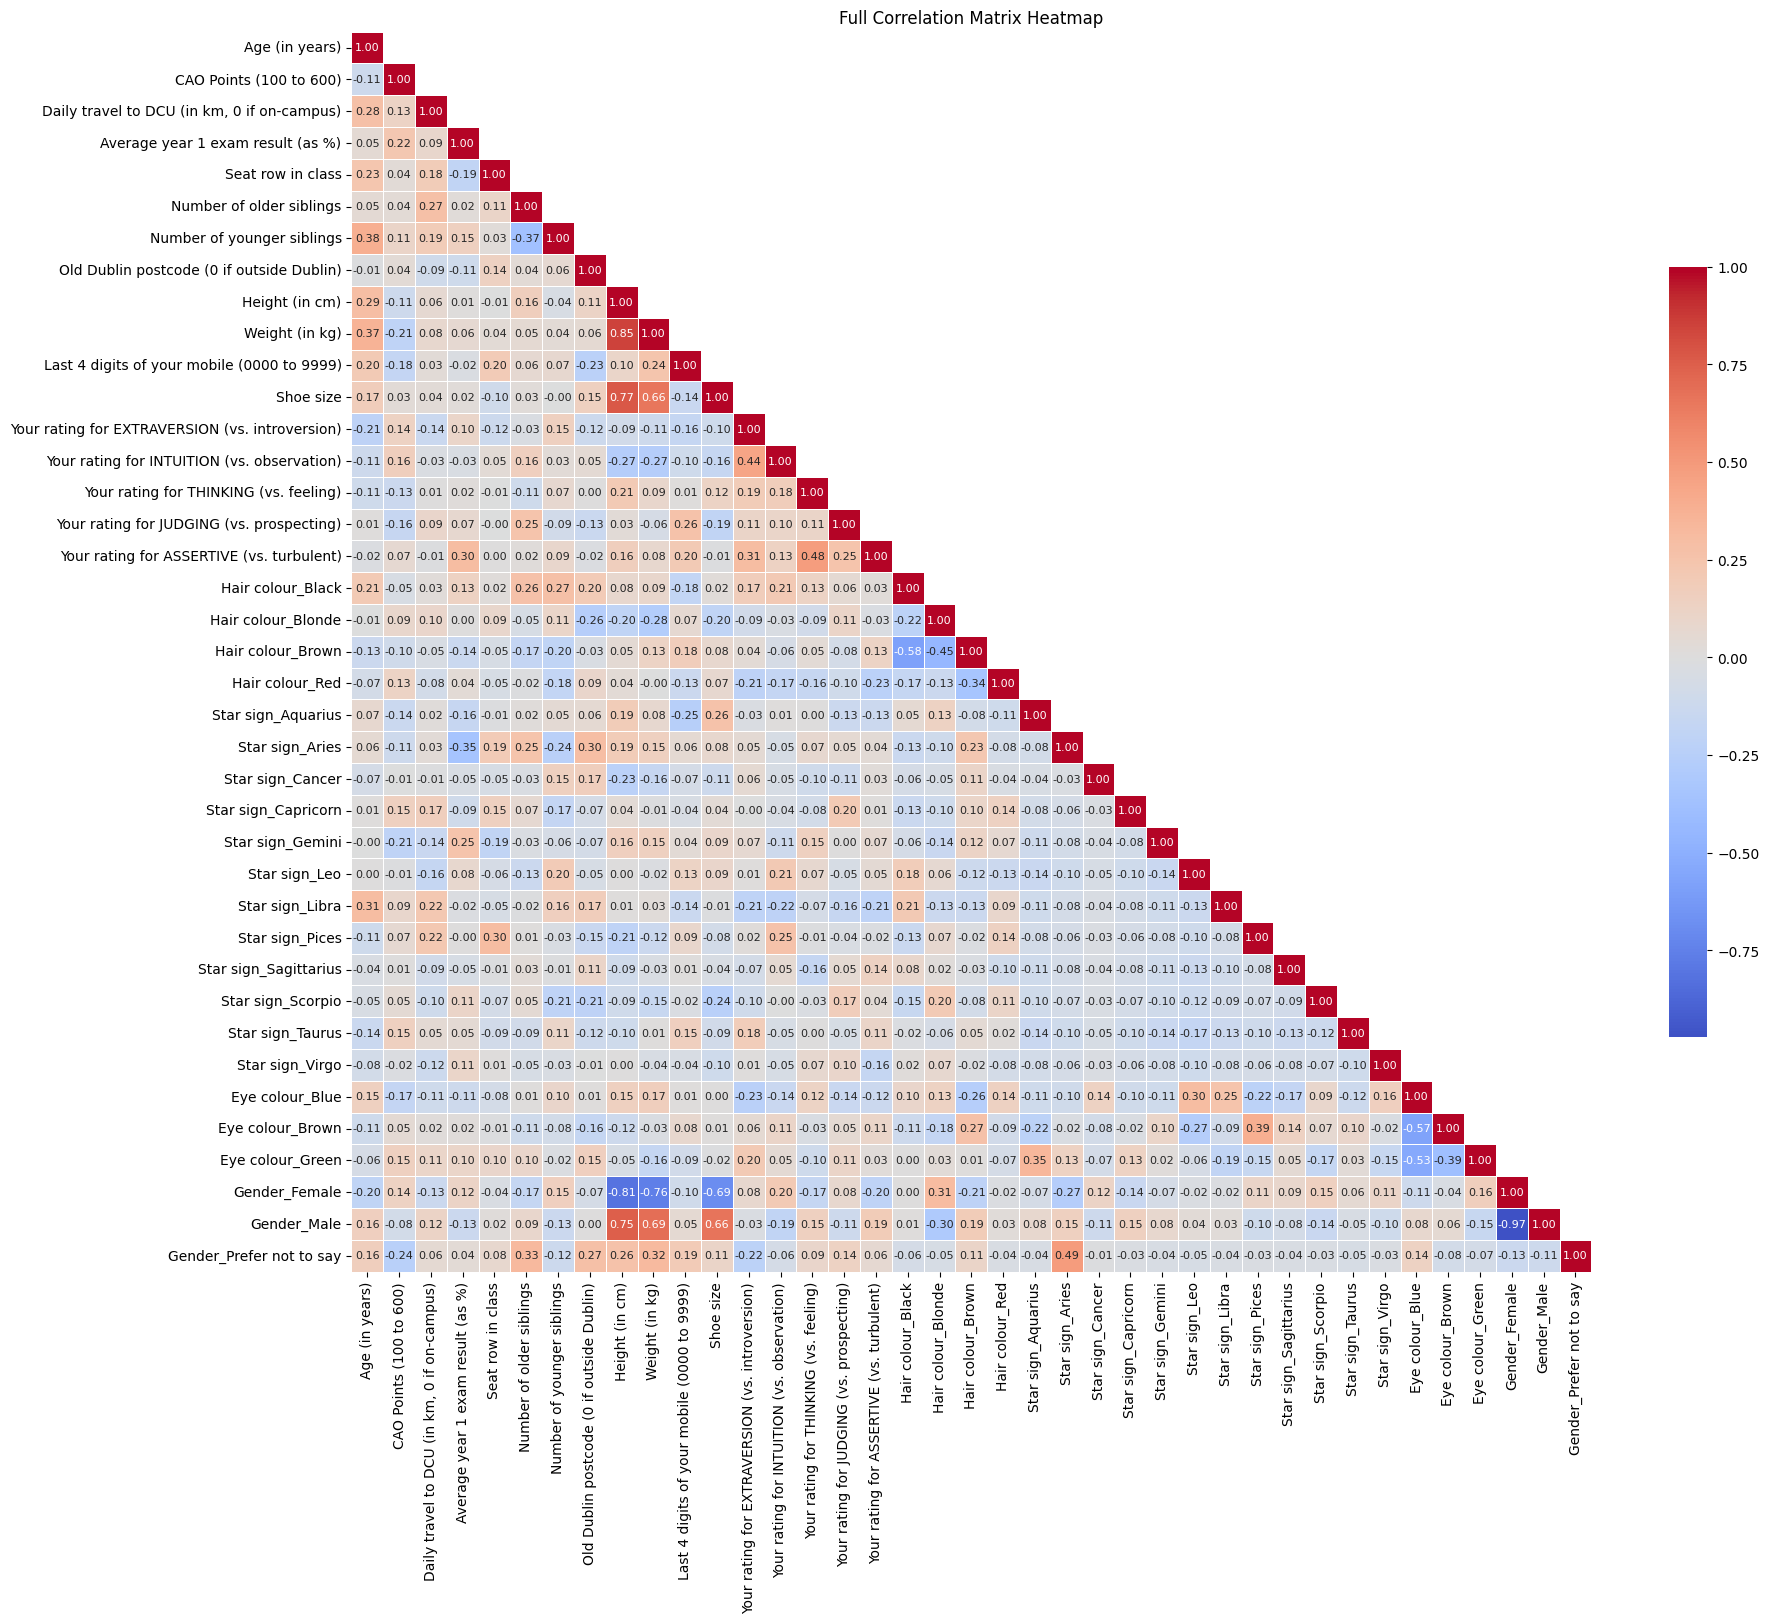

In [18]:
categorical_columns_nominal = ['Hair colour', 'Star sign', 'Eye colour', 'Gender']

data_encoded = pd.get_dummies(data, columns=categorical_columns_nominal, drop_first=False)

correlation_matrix = data_encoded.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(20, 20))

sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=".2f",
            annot=True, annot_kws={"size": 8})

plt.yticks(rotation=0)

plt.xticks(rotation=90)

plt.title('Full Correlation Matrix Heatmap')

png_file_path = '/Users/vincent/Desktop/As.1/FullCorrelationMatrix.png'

plt.savefig(png_path, bbox_inches='tight', dpi=600)

plt.show()

In [19]:
# 5 highest correlations of numerics (bei categorical bekommen wir komische ergenisse wegen der dummies)

numeric_data = data.select_dtypes(include=[np.number])

correlation_matrix = numeric_data.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

masked_correlation_matrix = correlation_matrix.mask(mask)

flat_correlations = masked_correlation_matrix.unstack().dropna().abs()

sorted_correlations = flat_correlations.sort_values(ascending=False)

print(sorted_correlations.head(5))

Height (in cm)                                   Weight (in kg)                                 0.852018
                                                 Shoe size                                      0.771973
Weight (in kg)                                   Shoe size                                      0.661187
Your rating for THINKING (vs. feeling)           Your rating for ASSERTIVE (vs. turbulent)      0.484129
Your rating for EXTRAVERSION (vs. introversion)  Your rating for INTUITION (vs. observation)    0.439097
dtype: float64


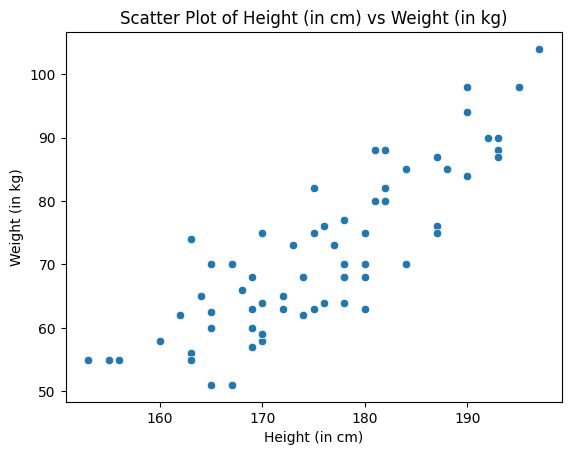

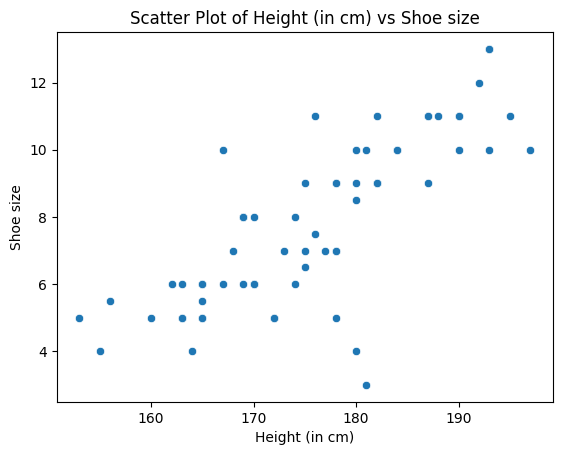

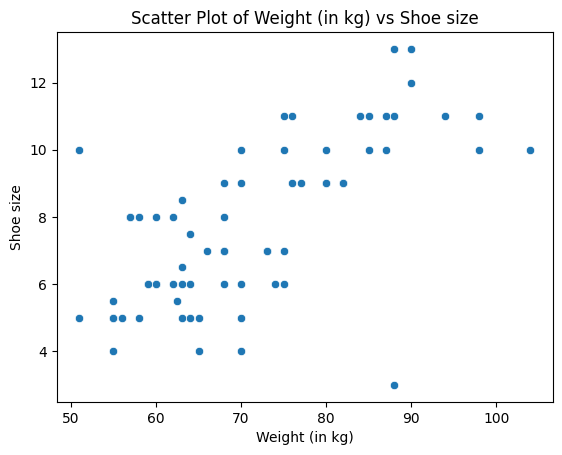

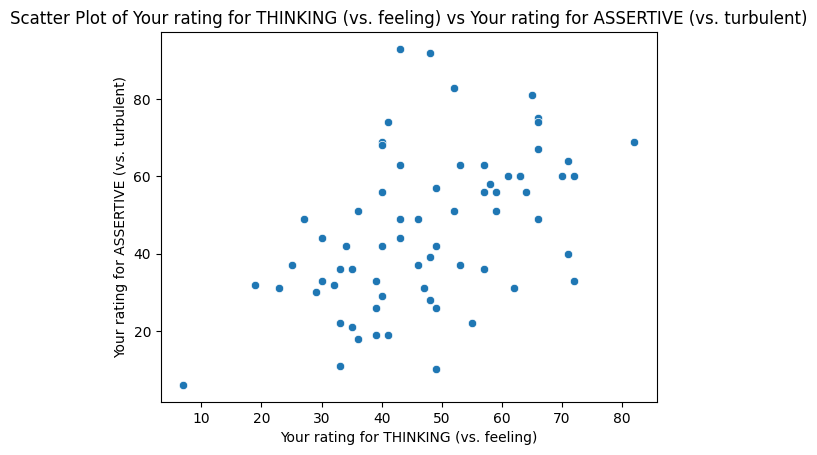

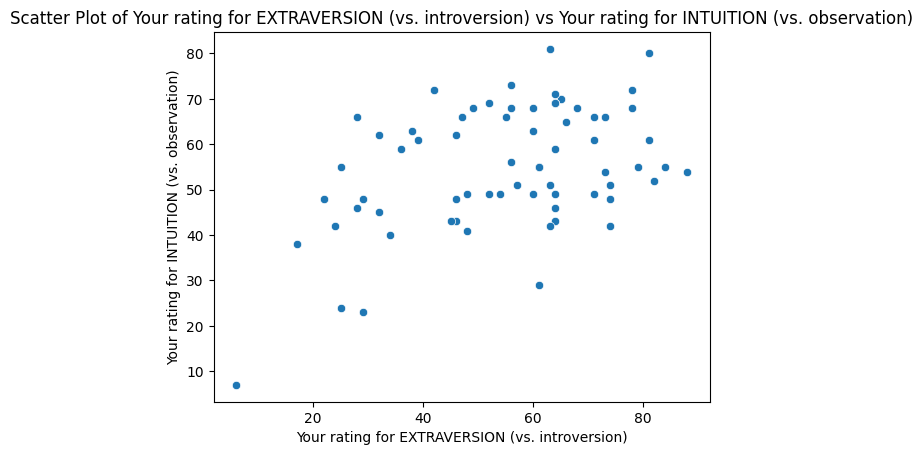

In [20]:
variable_pairs_high = [
    ('Height (in cm)', 'Weight (in kg)'),
    ('Height (in cm)', 'Shoe size'),
    ('Weight (in kg)', 'Shoe size'),
    ('Your rating for THINKING (vs. feeling)', 'Your rating for ASSERTIVE (vs. turbulent)'),
    ('Your rating for EXTRAVERSION (vs. introversion)', 'Your rating for INTUITION (vs. observation)')
]

for var1, var2 in variable_pairs_high:
    sns.scatterplot(x=numeric_data[var1], y=numeric_data[var2])
    plt.title(f'Scatter Plot of {var1} vs {var2}')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()

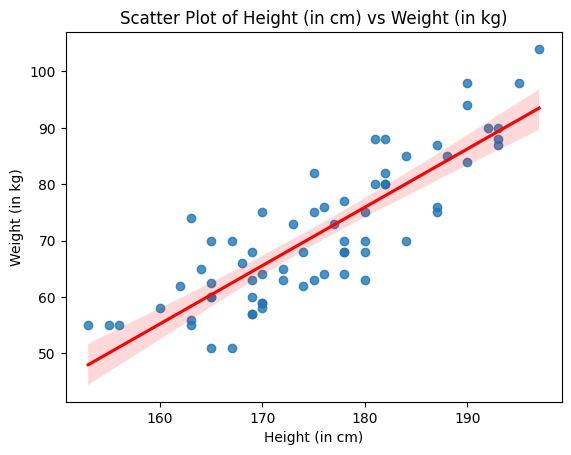

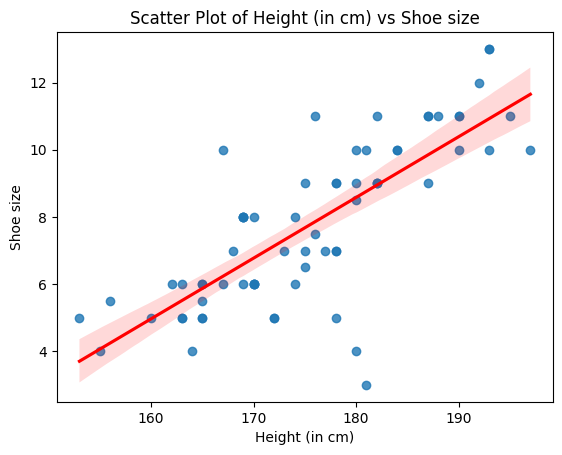

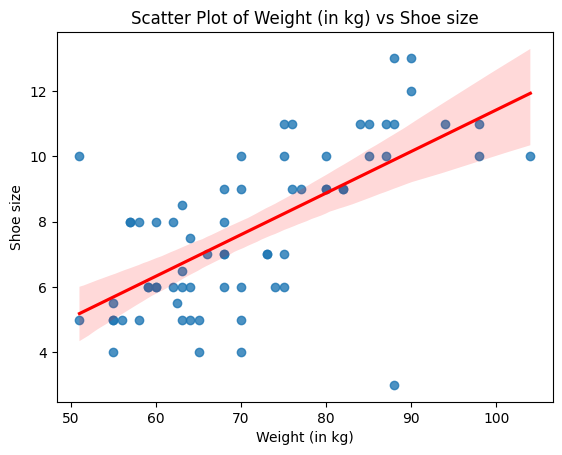

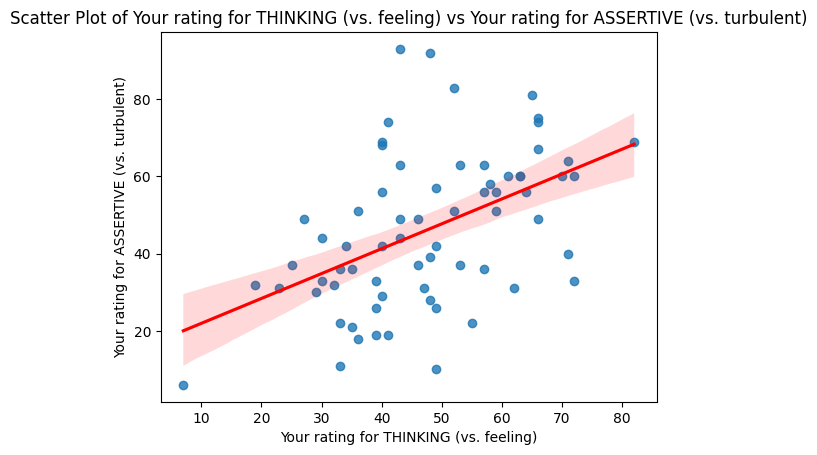

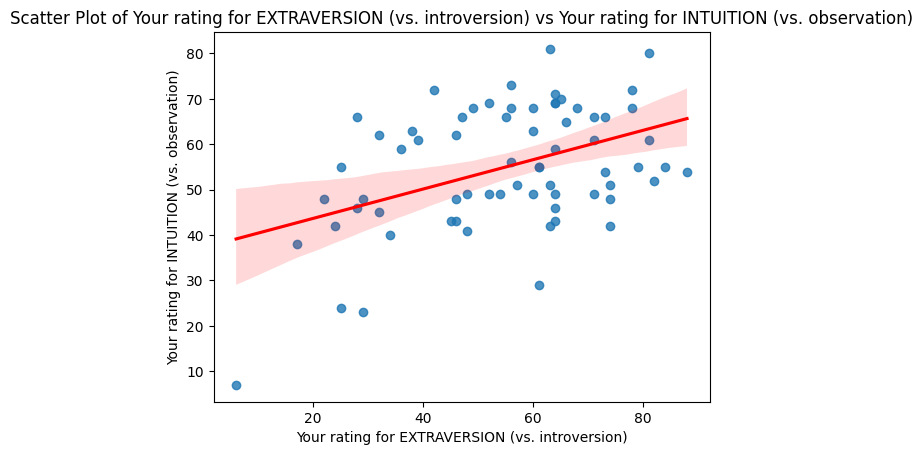

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

variable_pairs_high = [
    ('Height (in cm)', 'Weight (in kg)'),
    ('Height (in cm)', 'Shoe size'),
    ('Weight (in kg)', 'Shoe size'),
    ('Your rating for THINKING (vs. feeling)', 'Your rating for ASSERTIVE (vs. turbulent)'),
    ('Your rating for EXTRAVERSION (vs. introversion)', 'Your rating for INTUITION (vs. observation)')
]

# Specify the directory where you want to save the plots
output_directory = '/Users/vincent/Desktop/As.1/RegressionLines'

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

for var1, var2 in variable_pairs_high:
    sns.regplot(x=numeric_data[var1], y=numeric_data[var2], line_kws={"color": "red"})  # Add regression line
    plt.title(f'Scatter Plot of {var1} vs {var2}')
    plt.xlabel(var1)
    plt.ylabel(var2)
    
    # Correct the file name by replacing special characters and spaces
    filename = f'{var1}_vs_{var2}_regression_lines.png'.replace(' ', '_').replace('(', '').replace(')', '').replace('.', '')
    png_path = os.path.join(output_directory, filename)
    
    plt.savefig(png_path, bbox_inches='tight', dpi=600)
    plt.show()  # Move plt.show() after plt.savefig()
    
    plt.close()

#regression line withing 95% confidence interval

In [22]:
from scipy.stats import pearsonr

for var1, var2 in variable_pairs_high:
    correlation_coefficient, p_value = pearsonr(numeric_data[var1], numeric_data[var2])
    
    
    print(f"Correlation between {var1} and {var2}:")
    print(f"  Correlation coefficient: {correlation_coefficient:.6f}")
    print(f"  P-value: {p_value:.6e}")
    print() 
#high statistic significant based on p value

Correlation between Height (in cm) and Weight (in kg):
  Correlation coefficient: 0.852018
  P-value: 3.213051e-20

Correlation between Height (in cm) and Shoe size:
  Correlation coefficient: 0.771973
  P-value: 1.292258e-14

Correlation between Weight (in kg) and Shoe size:
  Correlation coefficient: 0.661187
  P-value: 8.410071e-10

Correlation between Your rating for THINKING (vs. feeling) and Your rating for ASSERTIVE (vs. turbulent):
  Correlation coefficient: 0.484129
  P-value: 2.878167e-05

Correlation between Your rating for EXTRAVERSION (vs. introversion) and Your rating for INTUITION (vs. observation):
  Correlation coefficient: 0.439097
  P-value: 1.797369e-04



In [23]:
# checking for inversive relationship 
numeric_data = data.select_dtypes(include=[np.number])

correlation_matrix = numeric_data.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

masked_correlation_matrix = correlation_matrix.mask(mask)

# Instead of dropping the negative correlations, sort the flattened correlations by their actual values, not their absolute values
flat_correlations = masked_correlation_matrix.unstack().dropna()

sorted_correlations = flat_correlations.sort_values()

print(sorted_correlations.head(5))

Number of older siblings                   Number of younger siblings                        -0.374471
Weight (in kg)                             Your rating for INTUITION (vs. observation)       -0.268230
Height (in cm)                             Your rating for INTUITION (vs. observation)       -0.266996
Old Dublin postcode (0 if outside Dublin)  Last 4 digits of your mobile (0000 to 9999)       -0.226607
Age (in years)                             Your rating for EXTRAVERSION (vs. introversion)   -0.211334
dtype: float64


In [24]:
from scipy.stats import pearsonr

variable_pairs_low = [
    ('Number of older siblings', 'Number of younger siblings'),
    ('Weight (in kg)', 'Your rating for INTUITION (vs. observation)'),
    ('Height (in cm)', 'Your rating for INTUITION (vs. observation)'),
    ('Old Dublin postcode (0 if outside Dublin)', 'Last 4 digits of your mobile (0000 to 9999)'),
    ('Age (in years)', 'Your rating for EXTRAVERSION (vs. introversion)')
]

for var1, var2 in variable_pairs_low:   
    series1 = numeric_data[var1]
    series2 = numeric_data[var2]
    
    
    corr_coefficient, p_value = pearsonr(series1, series2)
    
    print(f"Correlation and p-value for {var1} and {var2}:")
    print(f"  Correlation Coefficient: {corr_coefficient:.4f}")
    print(f"  P-value: {p_value:.4e}")
    print() 

#unliky to be coincidental, not as unlikly as high values

Correlation and p-value for Number of older siblings and Number of younger siblings:
  Correlation Coefficient: -0.3745
  P-value: 1.6550e-03

Correlation and p-value for Weight (in kg) and Your rating for INTUITION (vs. observation):
  Correlation Coefficient: -0.2682
  P-value: 2.6996e-02

Correlation and p-value for Height (in cm) and Your rating for INTUITION (vs. observation):
  Correlation Coefficient: -0.2670
  P-value: 2.7735e-02

Correlation and p-value for Old Dublin postcode (0 if outside Dublin) and Last 4 digits of your mobile (0000 to 9999):
  Correlation Coefficient: -0.2266
  P-value: 6.3132e-02

Correlation and p-value for Age (in years) and Your rating for EXTRAVERSION (vs. introversion):
  Correlation Coefficient: -0.2113
  P-value: 8.3631e-02



In [25]:
# data visualisation for numerics

# Adjust font sizes globally
plt.rcParams.update({'font.size': 8})  # Adjust the number to decrease or increase text size

# Plot histograms and suppress the output of the array
data.hist(bins=15, figsize=(15, 10), layout=(5, 4));

# Specify the directory where you want to save the plots
output_directory = '/Users/vincent/Desktop/As.1/Numerics_Distribution'

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Constructing file path for each plot
file_path = os.path.join(output_directory, f'{column}_numerics_distribution.png')
    
# Save the current figure to a PNG file
plt.savefig(file_path, dpi=300)  # dpi can be adjusted for higher resolution
plt.close()

In [26]:
#regression for personality traits 
import statsmodels.api as sm
X = numeric_data[['Age (in years)', 'CAO Points (100 to 600)', 'Average year 1 exam result (as %)',
                  'Daily travel to DCU (in km, 0 if on-campus)', 'Seat row in class', 'Number of older siblings',
                  'Number of younger siblings', 'Old Dublin postcode (0 if outside Dublin)', 'Height (in cm)',
                  'Weight (in kg)', 'Last 4 digits of your mobile (0000 to 9999)', 'Shoe size']]
X = sm.add_constant(X) 

personality_traits = [
    'Your rating for EXTRAVERSION (vs. introversion)',
    'Your rating for INTUITION (vs. observation)',
    'Your rating for THINKING (vs. feeling)',
    'Your rating for JUDGING (vs. prospecting)',
    'Your rating for ASSERTIVE (vs. turbulent)'
]
for trait in personality_traits:
    Y = numeric_data[trait]

    model = sm.OLS(Y, X).fit()
    
    print(f"Regression Analysis for: {trait}")
    print(model.summary())
    print("\n\n---\n\n")
    
    
#Taller individuals tend to have higher ratings for thinking (vs. feeling) (Coef = 1.0569, p-value = 0.013)
#Higher academic performance in the first year is associated with higher ratings for assertiveness (Coef = 0.6979, p-value = 0.011)
#Number of younger siblings positively influences intuition ratings (Coef = 2.7806, p-value = 0.248)
#Having more older siblings shows a positive trend with higher extraversion ratings (Coef = 3.4439, p-value = 0.188)
#Number of younger siblings doesn't significantly influence judging (vs. prospecting) ratings (Coef = 0.1020, p-value = 0.972)
#Weight has a negative trend with assertiveness ratings (Coef = -0.6095, p-value = 0.133)
#usw.

Regression Analysis for: Your rating for EXTRAVERSION (vs. introversion)
                                           OLS Regression Results                                          
Dep. Variable:     Your rating for EXTRAVERSION (vs. introversion)   R-squared:                       0.232
Model:                                                         OLS   Adj. R-squared:                  0.064
Method:                                              Least Squares   F-statistic:                     1.384
Date:                                             Mon, 26 Feb 2024   Prob (F-statistic):              0.201
Time:                                                     01:38:48   Log-Likelihood:                -285.70
No. Observations:                                               68   AIC:                             597.4
Df Residuals:                                                   55   BIC:                             626.3
Df Model:                                                      

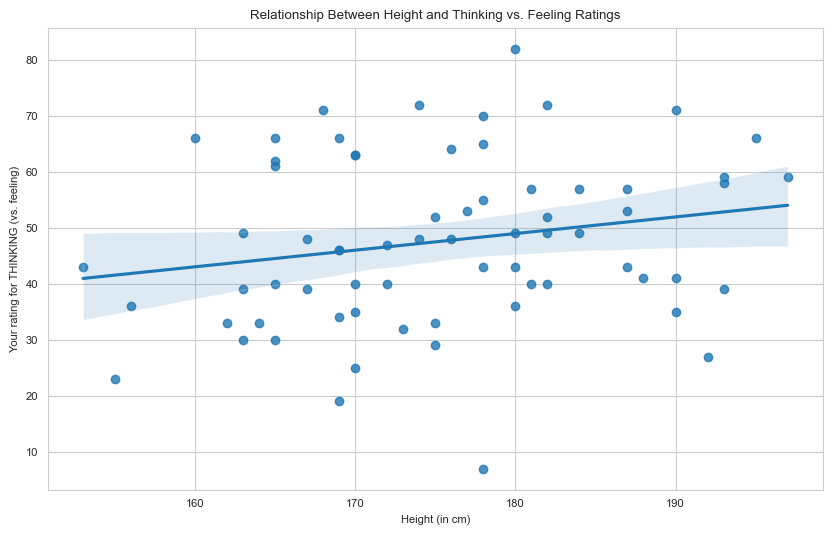

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.regplot(x='Height (in cm)', y='Your rating for THINKING (vs. feeling)', data=numeric_data)
plt.title('Relationship Between Height and Thinking vs. Feeling Ratings')
plt.xlabel('Height (in cm)')
plt.ylabel('Your rating for THINKING (vs. feeling)')

plt.show()

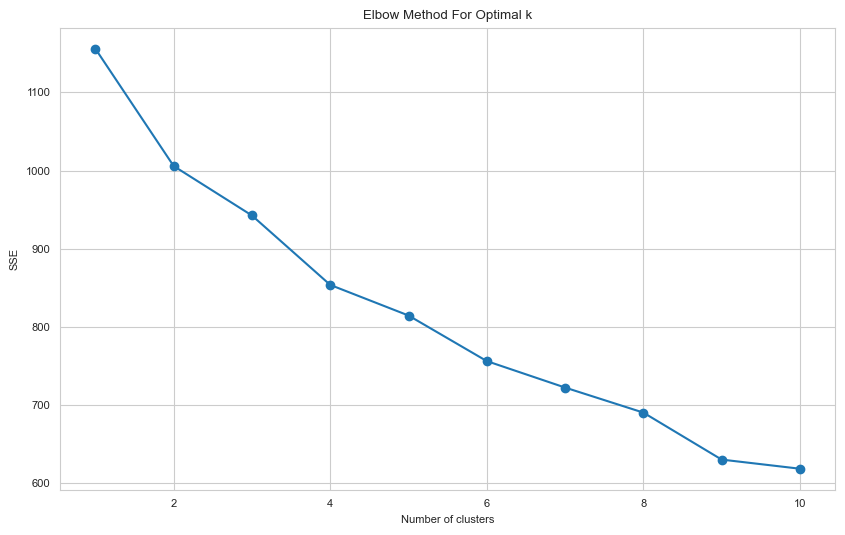

In [28]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

numeric_data = data.select_dtypes(include=[float, int])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

sse = [] 
for k in range(1, 11): 
    kmeans = KMeans(n_clusters=k,n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

In [29]:
k = 4
kmeans = KMeans(n_clusters=k,n_init=10, random_state=0)
clusters = kmeans.fit_predict(scaled_data)

data['Cluster'] = clusters

if scaled_data.shape[1] == 2:
    plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=clusters, cmap='viridis')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('2D Cluster Visualization')
    plt.show()
elif scaled_data.shape[1] == 3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(scaled_data[:, 0], scaled_data[:, 1], scaled_data[:, 2], c=clusters, cmap='viridis')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    plt.title('3D Cluster Visualization')
    plt.show()

data.head()

,Age (in years),CAO Points (100 to 600),"Daily travel to DCU (in km, 0 if on-campus)",Average year 1 exam result (as %),Seat row in class,Gender,Number of older siblings,Number of younger siblings,Old Dublin postcode (0 if outside Dublin),Height (in cm),...,Hair colour,Last 4 digits of your mobile (0000 to 9999),Star sign,Shoe size,Your rating for EXTRAVERSION (vs. introversion),Your rating for INTUITION (vs. observation),Your rating for THINKING (vs. feeling),Your rating for JUDGING (vs. prospecting),Your rating for ASSERTIVE (vs. turbulent),Cluster
0,22.0,505.0,10.021348,68.0,7.000000,Female,0,1,0,155.0,...,Brown,7181,Leo,4.0,32,62,23,35,31,3
1,19.0,543.0,10.000000,71.0,5.014425,Male,0,1,13,187.0,...,Red,838,Taurus,9.0,48,41,57,49,36,2
2,21.0,557.0,15.000000,50.5,10.000000,Male,2,0,15,178.0,...,Brown,4397,Aries,7.0,74,48,43,29,63,2
3,21.0,557.0,15.000000,50.5,10.000000,Male,2,0,15,178.0,...,Brown,4397,Aries,7.0,65,70,70,65,60,1
4,22.0,397.0,5.000000,65.0,5.000000,Female,2,0,0,153.0,...,Brown,8626,Sagittarius,5.0,25,55,43,61,44,3


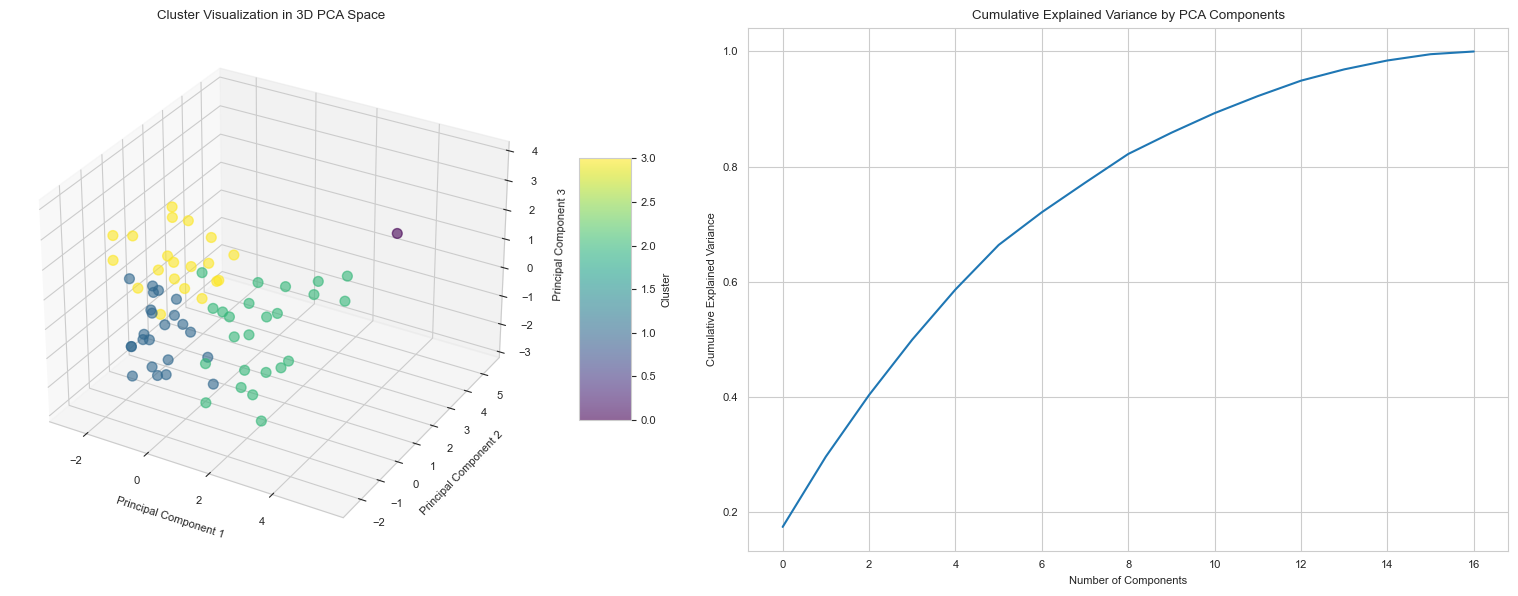

In [30]:
from sklearn.decomposition import PCA

numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
numeric_data = data[numeric_cols]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Fit PCA on the scaled data without specifying n_components to get all components
pca_full = PCA()
pca_full_result = pca_full.fit_transform(scaled_data)  # Fit and transform

# Create a 3D scatter plot with first 3 principal components
fig = plt.figure(figsize=(16, 6))

# 3D scatter plot
ax = fig.add_subplot(121, projection='3d')  # 3D subplot, position 1
scatter = ax.scatter(pca_full_result[:, 0], pca_full_result[:, 1], pca_full_result[:, 2], c=data['Cluster'], cmap='viridis', s=50, alpha=0.6)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('Cluster Visualization in 3D PCA Space')
cbar = plt.colorbar(scatter, shrink=0.5, pad=0.06, aspect=5)  # Color bar for clusters
cbar.set_label('Cluster')

# Cumulative explained variance plot
ax2 = fig.add_subplot(122)  # 2D subplot, position 2
ax2.plot(np.cumsum(pca_full.explained_variance_ratio_))
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance by PCA Components')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [31]:
print("Explained variance ratio by principal component:")
print(pca_full.explained_variance_ratio_)
total_variance_explained = sum(pca_full.explained_variance_ratio_)
print(f"Total variance explained by all selected components: {total_variance_explained:.2f}")

print("\nContribution of features to principal components:")
features = numeric_cols
for i, component in enumerate(pca_full.components_):
    component_contributions = dict(zip(features, component))
    sorted_contributions = sorted(component_contributions.items(), key=lambda x: x[1], reverse=True)
    print(f"\nPrincipal Component {i+1}:")
    for feature, contribution in sorted_contributions:
        print(f"{feature}: {contribution:.4f}")

Explained variance ratio by principal component:
[0.17376672 0.12220509 0.10700244 0.09629416 0.08709119 0.07738511
 0.05689373 0.05118978 0.05006372 0.03694678 0.0340751  0.02956392
 0.02682929 0.01962814 0.01545274 0.01090947 0.00470262]
Total variance explained by all selected components: 1.00

Contribution of features to principal components:

Principal Component 1:
Height (in cm): 0.5260
Weight (in kg): 0.5258
Shoe size: 0.4407
Age (in years): 0.3014
Last 4 digits of your mobile (0000 to 9999): 0.1370
Daily travel to DCU (in km, 0 if on-campus): 0.1148
Old Dublin postcode (0 if outside Dublin): 0.0674
Your rating for THINKING (vs. feeling): 0.0670
Number of older siblings: 0.0618
Seat row in class: 0.0581
Number of younger siblings: 0.0472
Your rating for ASSERTIVE (vs. turbulent): 0.0412
Average year 1 exam result (as %): 0.0173
Your rating for JUDGING (vs. prospecting): -0.0268
CAO Points (100 to 600): -0.1259
Your rating for EXTRAVERSION (vs. introversion): -0.1857
Your rating 

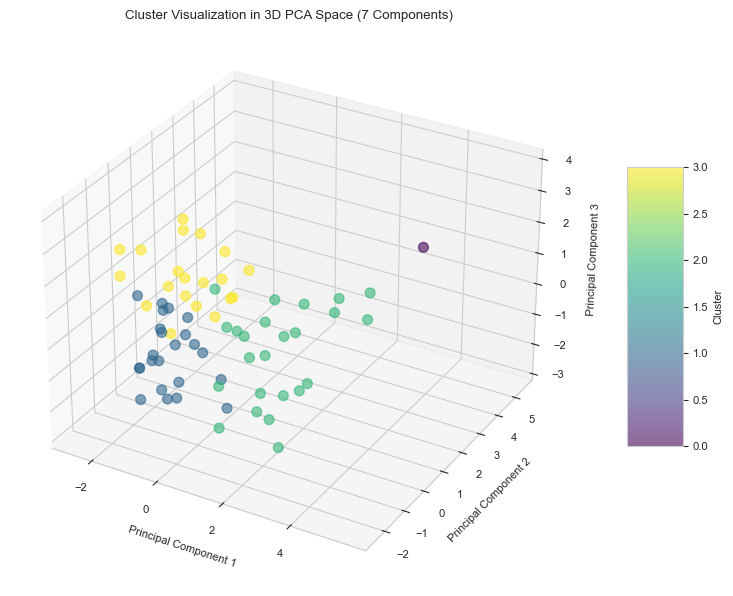

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' and 'StandardScaler' are already imported and defined
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
numeric_data = data[numeric_cols]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Fit PCA on the scaled data specifying n_components to get exactly 7 components
pca_7 = PCA(n_components=7)
pca_7_result = pca_7.fit_transform(scaled_data)  # Fit and transform

# Create a 3D scatter plot with the first 3 principal components of the 7-component PCA
fig = plt.figure(figsize=(10, 6))

# 3D scatter plot
ax = fig.add_subplot(111, projection='3d')  # 3D subplot
scatter = ax.scatter(pca_7_result[:, 0], pca_7_result[:, 1], pca_7_result[:, 2], c=data['Cluster'], cmap='viridis', s=50, alpha=0.6)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('Cluster Visualization in 3D PCA Space (7 Components)')
cbar = plt.colorbar(scatter, shrink=0.5, pad=0.06, aspect=5)  # Color bar for clusters
cbar.set_label('Cluster')

plt.tight_layout()
plt.show()


In [33]:
# Ensure 'pca_7' is your PCA model fitted with 7 components
print("Explained variance ratio by principal component:")
print(pca_7.explained_variance_ratio_)
total_variance_explained = sum(pca_7.explained_variance_ratio_)
print(f"Total variance explained by all selected components: {total_variance_explained:.2f}")

print("\nContribution of features to principal components:")
features = numeric_cols  # Make sure this is defined and contains the correct column names
for i, component in enumerate(pca_7.components_):
    component_contributions = dict(zip(features, component))
    sorted_contributions = sorted(component_contributions.items(), key=lambda x: x[1], reverse=True)
    print(f"\nPrincipal Component {i+1}:")
    for feature, contribution in sorted_contributions:
        print(f"{feature}: {contribution:.4f}")


Explained variance ratio by principal component:
[0.17376672 0.12220509 0.10700244 0.09629416 0.08709119 0.07738511
 0.05689373]
Total variance explained by all selected components: 0.72

Contribution of features to principal components:

Principal Component 1:
Height (in cm): 0.5260
Weight (in kg): 0.5258
Shoe size: 0.4407
Age (in years): 0.3014
Last 4 digits of your mobile (0000 to 9999): 0.1370
Daily travel to DCU (in km, 0 if on-campus): 0.1148
Old Dublin postcode (0 if outside Dublin): 0.0674
Your rating for THINKING (vs. feeling): 0.0670
Number of older siblings: 0.0618
Seat row in class: 0.0581
Number of younger siblings: 0.0472
Your rating for ASSERTIVE (vs. turbulent): 0.0412
Average year 1 exam result (as %): 0.0173
Your rating for JUDGING (vs. prospecting): -0.0268
CAO Points (100 to 600): -0.1259
Your rating for EXTRAVERSION (vs. introversion): -0.1857
Your rating for INTUITION (vs. observation): -0.2417

Principal Component 2:
Old Dublin postcode (0 if outside Dublin): 0.1

In [34]:
#7 components can explain about 72% of  the variance in this data set